# Classification of Heart Disease Using K-Nearest Neighbor

## Introduction
Many people die of cardiovascular diseases without knowing they have a problem with their heart. Unexpected deaths as such can be prevented with early diagnoses of cardiovascular issues and proper medication. In this project, we are trying to answer: Can available patient data and the KNN classification algorithm be used to detect the presence of heart diseases? If so, how accurate could it be and how to use it correctly in actual practice? The heart disease dataset we are using is obtained form the UCI machine learning repository (https://archive.ics.uci.edu/ml/datasets/Heart+Disease). It contains 303 patient instances and 14 attributes collected from Cleveland.  

## Preliminary Exploratory Data Analysis
#### 1. Download and Read the dataset from the web (use URL)

In [2]:
# Call packages that will be used.
library(tidyverse)
library(tidymodels)

In [3]:
# Set the value of seed to ensure reproducibility
set.seed(200)

In [4]:
# To download the dataset from the web
url <- 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
download.file(url,destfile='HeartDisease_Cleveland.csv')

In [5]:
# Read the 'HeartDisease_Cleveland.csv' file into a dataframe
heart_cleve <- read_csv('HeartDisease_Cleveland.csv',col_names=FALSE)
head(heart_cleve)

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double(),
  X10 = col_double(),
  X11 = col_double(),
  X12 = col_character(),
  X13 = col_character(),
  X14 = col_double()
)



X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


#### 2. Clean and Wrangle data into tidy format

In [6]:
# Clean and Wrangle the data into tidy format
heart_cleve <- rename(heart_cleve, age = X1,
               sex = X2,
               cp = X3,
               trestbps = X4,
               chol = X5,
               fbs = X6,
               restecg = X7,
               thalach = X8,
               exang = X9,
               oldpeak = X10,
               slope = X11,
               ca = X12,
               thal = X13,
               num = X14) %>% 
            mutate(num = as_factor(num),ca = as.numeric(ca),thal = as.numeric(ca))
head(heart_cleve)

Warning message:
“Problem with `mutate()` input `ca`.
ℹ NAs introduced by coercion
ℹ Input `ca` is `as.numeric(ca)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,0,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
67,1,4,120,229,0,2,129,1,2.6,2,2,2,1
37,1,3,130,250,0,0,187,0,3.5,3,0,0,0
41,0,2,130,204,0,2,172,0,1.4,1,0,0,0
56,1,2,120,236,0,0,178,0,0.8,1,0,0,0


#### 4. Summary statistics about the training data

In [7]:
# Split the dataset into training and test sets

heart_split <- initial_split(heart_cleve,prop=0.75,strata=num)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

In [8]:
# Summary Statistics about the training data

# number of observations in each class
heart_sum_class <- heart_train %>% 
                group_by(num) %>%
                summarise(n=n())
heart_sum_class

`summarise()` ungrouping output (override with `.groups` argument)



num,n
<fct>,<int>
0,123
1,40
2,28
3,28
4,10


In [10]:
# summary statistics of predictor variables used in analysis
options(digits=2)
heart_percentile <- heart_train %>%
                    select(-num) %>%
                    map_df(quantile,na.rm=TRUE) 

heart_1stQ <- heart_percentile %>%
                select('25%') %>%
                t()%>%
                as.vector()

heart_3rdQ <- heart_percentile %>%
                select('75%') %>%
                t() %>%
                as.vector()

heart_mean <- heart_train%>% 
                    select(-num) %>%
                    map_df(mean,na.rm = TRUE)

heart_min <- heart_train %>%
                    select(-num) %>%
                    map_df(min,na.rm=TRUE)

heart_max <- heart_train %>%
                    select(-num) %>%
                    map_df(max,na.rm=TRUE)

heart_median <- heart_train %>%
                    select(-num) %>%
                    map_df(median,na.rm=TRUE)

heart_range <- heart_max - heart_min

heart_missing <- colSums(is.na(heart_train%>%select(-num)))
# Source: https://stackoverflow.com/questions/26273663/r-how-to-total-the-number-of-na-in-each-col-of-data-frame

heart_sum_pred <- rbind(heart_min, heart_1stQ, heart_median,heart_mean, heart_3rdQ, heart_max, heart_range, heart_missing) %>%
                    mutate(Statistics=c('Min','First Quartile','Median','Mean','Third Quartile','Max','Range','# of Missing Value'),.before=age)
heart_sum_pred

Statistics,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Min,29,0.00,1.0,94,126,0.00,0,71,0.0,0.0,1.0,0.00,0.00
First Quartile,48,0.00,3.0,120,209,0.00,0,133,0.0,0.0,1.0,0.00,0.00
Median,55,1.00,3.0,130,239,0.00,1,153,0.0,0.8,2.0,0.00,0.00
Mean,54,0.68,3.2,132,246,0.15,1,149,0.3,1.0,1.6,0.64,0.64
Third Quartile,61,1.00,4.0,140,274,0.00,2,166,1.0,1.6,2.0,1.00,1.00
Max,77,1.00,4.0,200,564,1.00,2,202,1.0,6.2,3.0,3.00,3.00
Range,48,1.00,3.0,106,438,1.00,2,131,1.0,6.2,2.0,3.00,3.00
# of Missing Value,0,0.00,0.0,0,0,0.00,0,0,0.0,0.0,0.0,3.00,3.00


In [11]:
#summary(heart_train)

#### 4. Visualize the training data
    - compare the distributions of each of the predictor variables used in the analysis

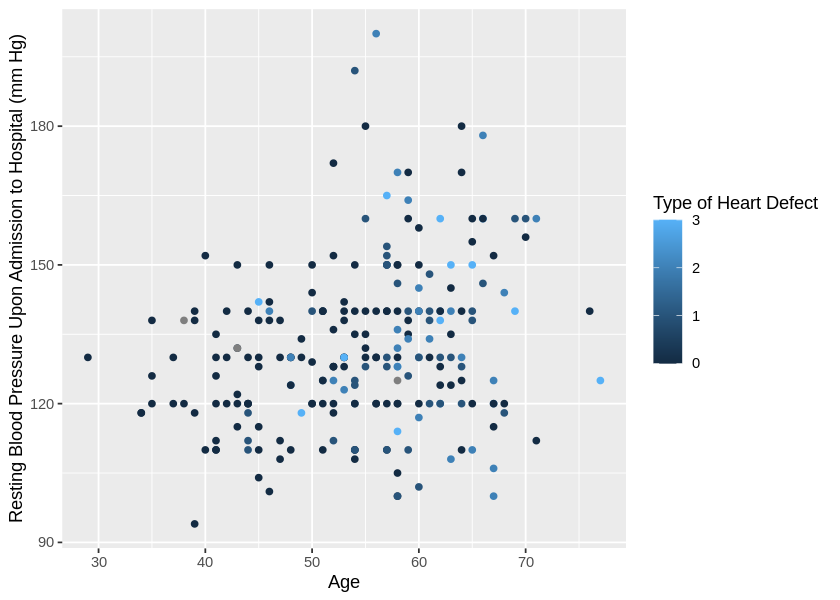

In [14]:
options(repr.plot.width=7,repr.plot.height=5)
heart_plot <- heart_train %>%
ggplot(aes(x=age, y=trestbps, colour = thal)) +
geom_point() +
labs(x = "Age", y = "Resting Blood Pressure Upon Admission to Hospital (mm Hg)", colour = "Type of Heart Defect") 

heart_plot
# ggpairs(df)

## Methods
- Explain how to conduct the data analysis
- Explain which variables you will use
- Describe at least one way you will visualize the results

## Expected Outcomes and Significance
- What do you expect to find?
- What impact could such findings have?
- What future questions could this lead to?